In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model

from keras.layers import Activation, Dense, Dropout, Input, Embedding, Bidirectional 
from keras.layers import Flatten, Conv1D, MaxPooling1D
from keras.models import Model

from keras.optimizers import RMSprop

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence

from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import re

import gensim
#from pymystem3 import Mystem
#from stanfordcorenlp import StanfordCoreNLP
import spacy_udpipe

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../../task2_data/task2_en_training.tsv',delimiter='\t')
df.head()

,tweet_id,user_id,class,tweet
0,344266386467606528,809439366,0,"depression hurts, cymbalta can help"
1,349220537903489025,323112996,0,"@jessicama20045 right, but cipro can make thin..."
2,351421773079781378,713100330,0,@fibby1123 are you on paxil .. i need help
3,326594278472171520,543113070,0,@redicine the lamotrigine and sjs just made ch...
4,345567138376994816,138795534,0,have decided to skip my #humira shot today. my...


In [4]:
spacy_udpipe.download("en")
nlp = spacy_udpipe.load("en")
model = gensim.models.KeyedVectors.load_word2vec_format("../../Embeddings/model.bin", binary=True) 
#model.vocab 

Already downloaded a model for the 'en' language


In [5]:
def lemmatize_with_postag(text = """"Wikipedia is a free online encyclopedia, created and 
                          edited by volunteers around the world.""",
                          nlp=nlp):
    doc = nlp(text)
    tagged = []
    for token in doc:
        lemma = token.lemma_
        if lemma[0] in '@?':
            continue        
        pos = token.pos_
        #pos = pos.split('=')[0].strip()
        if pos not in ["PUNCT"]: #["VERB", "NUM", "ADV", "NOUN", "ADJ", "AUX", "PRON", "ADP", "DET", "ADV", "INTJ", "PROPN"]:
            tagged.append(lemma.lower() + '_' + pos)
        #else : print(pos)
    return tagged

In [6]:
X_train = df['tweet']
y_train = df['class']

Xy = pd.concat([X_train, y_train], axis=1)



# paramters of the text praprations
n_items_for_train = 500
n_items_for_test  = 200
max_words         = 8000 

# n_items_for_train твитов для тренировки с индексом класса 1
df_1 = Xy[Xy['class'] == 1].iloc[:1500] 
# n_items_for_train твитов для тренировки с индексом класса 0
df_0 = Xy[Xy['class'] == 0].iloc[:2800] 

Xy_ = shuffle(pd.concat([df_0, df_1]))
Xy_train = pd.concat([Xy_["tweet"].apply(lemmatize_with_postag), Xy_["class"]], axis = 1)



# n_items_for_test твитов для теста с индексом класса 1
df_1 = Xy[Xy['class'] == 1].iloc[1500:]
# n_items_for_test твитов для теста с индексом класса 0
df_0 = Xy[Xy['class'] == 0].iloc[2000:2900]

Xy_ = shuffle(pd.concat([df_0, df_1]))
Xy_test = pd.concat([Xy_["tweet"].apply(lemmatize_with_postag), Xy_["class"]], axis = 1)

print(Xy_train.shape)
print(Xy_test.shape)
#Xy_train, Xy_test

n_items_for_train = len(Xy_train)
n_items_for_test = len(Xy_test)

(4300, 2)
(1303, 2)


AxesSubplot(0.125,0.125;0.775x0.755)


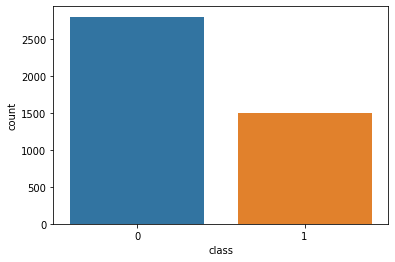

In [7]:
import seaborn as sns
print(sns.countplot(Xy_train['class']))

AxesSubplot(0.125,0.125;0.775x0.755)


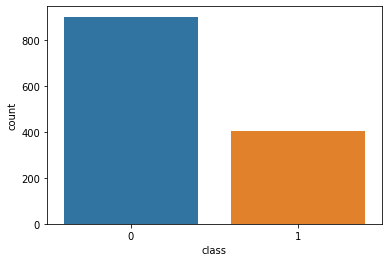

In [8]:
print(sns.countplot(Xy_test['class']))

In [9]:
# replcade as parameter in the begining
#max_words = 2000 # ограничение вокуабуляра

maxima = 0
for ar in Xy_train['tweet'].to_list():
    if len(ar)>maxima: maxima = len(ar)
for ar in Xy_test['tweet']:
    if len(ar)>maxima: maxima = len(ar)
max_len = maxima + 1
print(f'max_len = {max_len}')

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Xy_train["tweet"]) #fit on train

# exctrax features from train
sequences_train = tok.texts_to_sequences(Xy_train["tweet"])
sequences_matrix_train = sequence.pad_sequences(sequences_train, maxlen=max_len)

# exctrax features from test
sequences_test = tok.texts_to_sequences(Xy_test["tweet"])
sequences_matrix_test = sequence.pad_sequences(sequences_test, maxlen=max_len)

max_len = 36


In [10]:
def fix_word_key(string):
    upper_part = (re.findall('_.*',string))[0].upper()
    result = re.sub(r'_.*', upper_part, string)
    #print(f'was {string} -> became {result}')
    return result

word_index = tok.word_index
#print('Found %s unique tokens' % len(word_index))

wi1 = len(word_index)

# fix tokenizer problem
for key in word_index.keys():
    fixed_key = fix_word_key(key)
    word_index[fixed_key] = word_index.pop(key)
    
#print('Found %s unique tokens' % len(word_index))
wi2 = len(word_index)

if wi1 != wi2:
    print()
    error = 'lenght of word_index was changed!'
    print(error.upper())
    raise ValueError
else:
    print('Everything is OK')
    print(len(word_index))

Everything is OK
9838


In [11]:
# делаем Embedding на основе w2v модели

nb_words = min(max_words, len(word_index))+1 # проверяем где меньше, в нашем датасете или в токенайзере.
EMBEDDING_DIM = 300 # размерность векторов в нашей модели w2v

print(f'number of words = {nb_words}')

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
print(embedding_matrix.shape)

counter = 0
for word, i in word_index.items():
    if i >= nb_words: continue
    if word in model.vocab:
        #print(model[word])
        embedding_matrix[i] = model[word]
#     if counter > nb_words: break
#     counter += 1


print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
#pd.DataFrame(embedding_matrix)

number of words = 8001
(8001, 300)
Null word embeddings: 4904


In [12]:
len(sequences_matrix_train)

4300

# CNN

In [13]:
rate_drop_dense = 0.15 + np.random.rand() * 0.25
act = 'relu'

embedding_layer      = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=False) 

# CONFIGURATION OF CNN
sequence_1_input     = Input(shape=(max_len,), dtype='int32')
x                    = embedding_layer(sequence_1_input)

x                    = Conv1D(filters=300, kernel_size=3, activation='relu', input_shape=(x.shape))(x)
x                    = Dropout(0.5)(x)
x                    = MaxPooling1D(pool_size=2)(x)

x                    = Conv1D(filters=300, kernel_size=5, activation='relu', input_shape=(x.shape))(x)
x                    = Dropout(0.5)(x)
x                    = MaxPooling1D(pool_size=1)(x)

# for filter_num, filter_size, pooling_size in conv_layers:
#     x = Conv1D(filter_num, filter_size)(x)
#     x = Activation('relu')(x)
#     if pooling_size != -1:
#         x = MaxPooling1D(pool_size=pooling_size)(x)
        
x                    = Flatten()(x)

# for dense_size in fully_connected_layers:
#     x = Dense(dense_size, activation='relu')(x)
#     x = Dropout(dropout_p)(x)

merged               = Dropout(rate_drop_dense)(x)
merged               = BatchNormalization()(merged)
merged               = Dense(32, activation=act)(merged)
merged               = Dropout(rate_drop_dense)(merged)
merged               = BatchNormalization()(merged)
preds                = Dense(2, activation='softmax')(merged)

In [14]:
STAMP = 'CNN'

model = Model(inputs=[sequence_1_input], outputs=preds)
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])
model.summary()
print(STAMP, end='\n\n')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 36)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 36, 300)           2400300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 300)           270300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 34, 300)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 300)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 300)           450300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 300)           0   

In [15]:
from keras.utils import to_categorical

Xy_train = to_categorical(Xy_train['class'], num_classes=2)
Xy_test = to_categorical(Xy_test['class'], num_classes=2)

In [16]:
epochs = 10
batch_size = 64
patience = 20


early_stopping =EarlyStopping(monitor='val_loss', patience=patience)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

history = model.fit(sequences_matrix_train, Xy_train, 
                 validation_data=(sequences_matrix_test[:n_items_for_test//2], 
                                  Xy_test[:n_items_for_test//2]), 
                 epochs=epochs, batch_size=batch_size, shuffle=True,
                 callbacks=[early_stopping, model_checkpoint])

Train on 4300 samples, validate on 651 samples
Epoch 1/10
4300/4300 [==============================] - 9s 2ms/step - loss: 0.7547 - acc: 0.6253 - val_loss: 0.5945 - val_acc: 0.7127
Epoch 2/10
4300/4300 [==============================] - 7s 2ms/step - loss: 0.5972 - acc: 0.7098 - val_loss: 0.5672 - val_acc: 0.7127
Epoch 3/10
4300/4300 [==============================] - 6s 1ms/step - loss: 0.5176 - acc: 0.7616 - val_loss: 0.5403 - val_acc: 0.7573
Epoch 4/10
4300/4300 [==============================] - 7s 2ms/step - loss: 0.4574 - acc: 0.7984 - val_loss: 0.5067 - val_acc: 0.7742
Epoch 5/10
4300/4300 [==============================] - 6s 2ms/step - loss: 0.4260 - acc: 0.8119 - val_loss: 0.4784 - val_acc: 0.7757
Epoch 6/10
4300/4300 [==============================] - 7s 2ms/step - loss: 0.3904 - acc: 0.8258 - val_loss: 0.4622 - val_acc: 0.7834
Epoch 7/10
4300/4300 [==============================] - 7s 2ms/step - loss: 0.3495 - acc: 0.8440 - val_loss: 0.4364 - val_acc: 0.8003
Epoch 8/10
4300

In [18]:
history.history['val_acc'][-1]

0.8064516186714172

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) 

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
pred = model.predict(sequences_matrix_test[n_items_for_test//2:])
pred.shape
bin_pred, real = [], np.array(Xy_test)[n_items_for_test//2:]
for i in range(len(pred)):
    #print(f'pred = {int(round(float(pred[i][0]), 0))},\t real = {real[i]}')
    bin_pred.append(int(round(float(pred[i][0]), 0))) 

In [ ]:
len(bin_pred), len(real), len(pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report([r[0] for r in real], bin_pred))

In [ ]:
pd.DataFrame(confusion_matrix([r[0] for r in real], bin_pred), columns=['Pos', 'Neg'])